# Experiments Gaussian HHM

In [1]:
from dynamax.hidden_markov_model import GaussianHMM
from dynamax.hidden_markov_model import DiagonalGaussianHMM
from dynamax.hidden_markov_model import SphericalGaussianHMM
from dynamax.hidden_markov_model import SharedCovarianceGaussianHMM
import matplotlib.pyplot as plt
import hmm_datasets as hd
import gauss_hmm as gh
import jax.random as jr
import jax.numpy as jnp

In [2]:
# Inputs for gathering the data
path = './data/stocks'
old_first = True
start = '2022-01-01'
end = '2022-12-31'
sep = '_'
period_len = 60
stocks = hd.StockData(path = path,
                      start = start,
                      end = end, 
                      old_first = old_first,
                      sep=sep)

# Inputs for training the model
key = jr.PRNGKey(10)
init_method = 'prior'

## Log returns using Adj Close price

* `mkt_ret` (jnp.array) contains the returns of all stocks in one table. Shape is (batches, period_len, attributes)
* `stk_ret` (Dict) is a dictionary with arrays containing the returns of each stock series. The shape of each array is (batches, period_len, attributes)

In [3]:
# Log return data
returns = stocks.get_log_returns()
mkt_ret = hd.join(returns)
mkt_ret = hd.create_batches(mkt_ret.to_numpy(),
                                  period_len = period_len,
                                  old_first = old_first)
stk_ret = {}
for s in returns.keys():
    stk_ret[s] = hd.create_batches(returns[s].to_numpy(), period_len = period_len, old_first = old_first)

### Create folds using one-batch-out
* `mkt_folds` (list). List containing the folds for mkt_ret.
* `stk_folds` (Dict). Dictionary with lists. Each list contains the fold of a stock series.

In [4]:
# Input: Embargo parameter 
# (See Lopez de Prado - Advances in Financial Machine Learning, Chapter 7)
e = 5

In [5]:
# Folds for mkt_ret
mkt_folds = hd.make_folds(mkt_ret, e)

In [6]:
# Folds for each stock
stk_folds = {}
for s in stk_ret:
    stk_folds[s] = hd.make_folds(stk_ret[s], e)

### Find the number of hidden states using cross-validation (whole market interpretation)

**NOTE**: I can't apply product kernel to this approach (there's nothing to compare with!!)

In [ ]:
model = SharedCovarianceGaussianHMM

In [ ]:
# Using whole market perspective
states = list(range(2, 10))
avgloglike = gh.cross_val_states_em(model, states, mkt_folds, init_method, key)

In [ ]:
plt.plot(states, avgloglike, '.-', markersize = 16)
plt.xlabel('Number of states')
plt.ylabel('Average validation marginal log prob')
plt.title(f'{model.__name__}')
plt.grid()
plt.show()
plt.close()

In [ ]:
# Train best model for the market as a whole
mkt_num_states = states[jnp.argmax(avgloglike)]
mkt_model, mkt_param, mkt_loglik = gh.fit_model_em(model, mkt_ret, mkt_num_states, init_method, key)

### Find the number of hidden states using cross-validation (stock-wise)

In [7]:
model = SharedCovarianceGaussianHMM
states = list(range(2, 10))


 === Fitting data from AAPL === 


 === Starting fitting with 2 states === 

 |████████████████████| 100.00% [50/50 00:00<00:00]
 === Starting fitting with 3 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 4 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 5 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 6 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 7 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 8 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 9 states === 



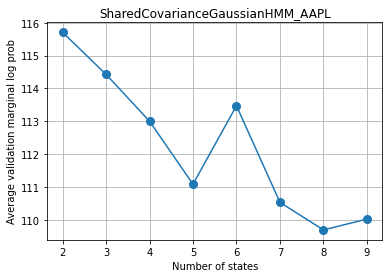


 === Fitting data from ABBV === 


 === Starting fitting with 2 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 3 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 4 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 5 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 6 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 7 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 8 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 9 states === 



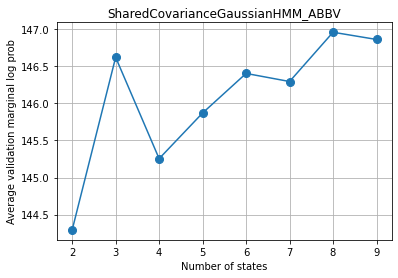


 === Fitting data from ABT === 


 === Starting fitting with 2 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 3 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 4 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 5 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 6 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 7 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 8 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 9 states === 



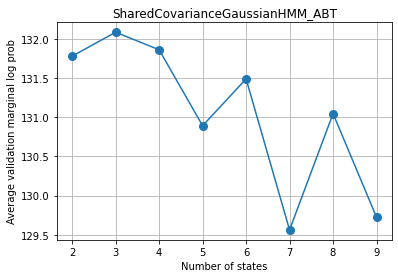


 === Fitting data from ACN === 


 === Starting fitting with 2 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 3 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 4 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 5 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 6 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 7 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 8 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 9 states === 



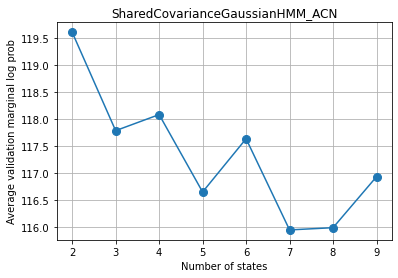


 === Fitting data from ADBE === 


 === Starting fitting with 2 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 3 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 4 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 5 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 6 states === 

 |████████████████████| 100.00% [50/50 00:02<00:00]
 === Starting fitting with 7 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 8 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 9 states === 



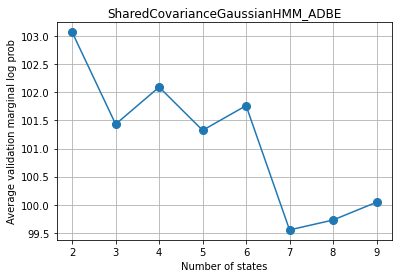


 === Fitting data from AMZN === 


 === Starting fitting with 2 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 3 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 4 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 5 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 6 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 7 states === 

 |████████████████████| 100.00% [50/50 00:02<00:00]
 === Starting fitting with 8 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 9 states === 



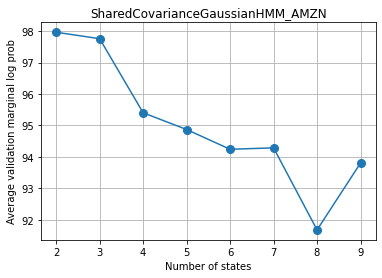


 === Fitting data from AVGO === 


 === Starting fitting with 2 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 3 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 4 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 5 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 6 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 7 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 8 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 9 states === 



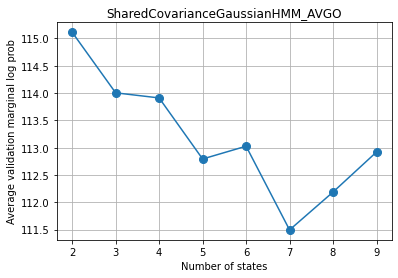


 === Fitting data from BAC === 


 === Starting fitting with 2 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 3 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 4 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 5 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 6 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 7 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 8 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 9 states === 



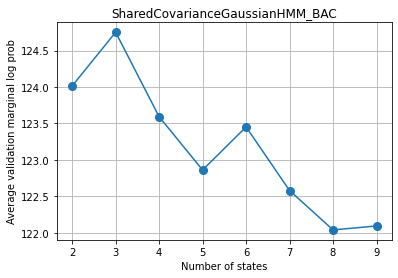


 === Fitting data from BMY === 


 === Starting fitting with 2 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 3 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 4 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 5 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 6 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 7 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 8 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 9 states === 



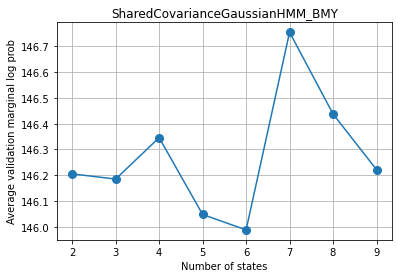


 === Fitting data from BRK-B === 


 === Starting fitting with 2 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 3 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 4 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 5 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 6 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 7 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 8 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 9 states === 



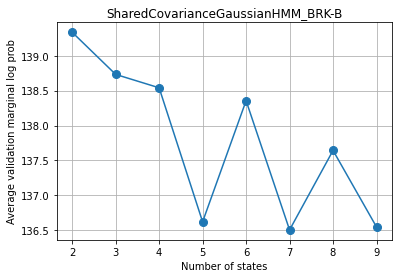


 === Fitting data from CMCSA === 


 === Starting fitting with 2 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 3 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 4 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 5 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 6 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 7 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 8 states === 

 |████████████████████| 100.00% [50/50 00:04<00:00]
 === Starting fitting with 9 states === 



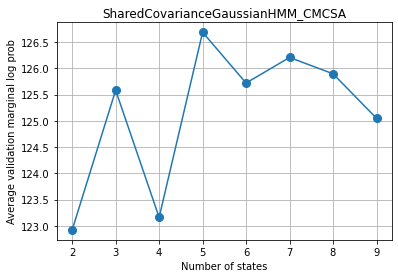


 === Fitting data from COST === 


 === Starting fitting with 2 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 3 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 4 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 5 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 6 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 7 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 8 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 9 states === 



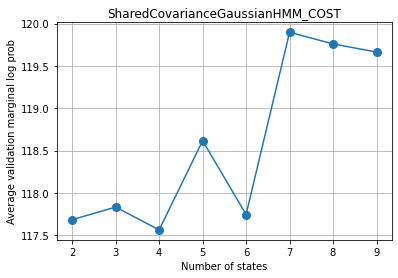


 === Fitting data from CRM === 


 === Starting fitting with 2 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 3 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 4 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 5 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 6 states === 

 |████████████████████| 100.00% [50/50 00:02<00:00]
 === Starting fitting with 7 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 8 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 9 states === 



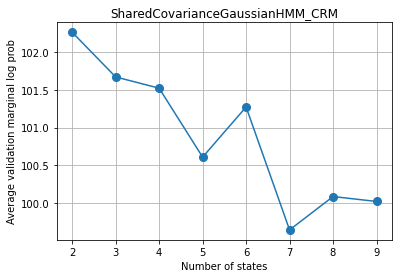


 === Fitting data from CSCO === 


 === Starting fitting with 2 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 3 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 4 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 5 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 6 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 7 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 8 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 9 states === 



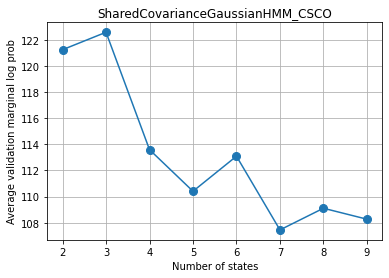


 === Fitting data from CVX === 


 === Starting fitting with 2 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 3 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 4 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 5 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 6 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 7 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 8 states === 

 |████████████████████| 100.00% [50/50 00:04<00:00]
 === Starting fitting with 9 states === 



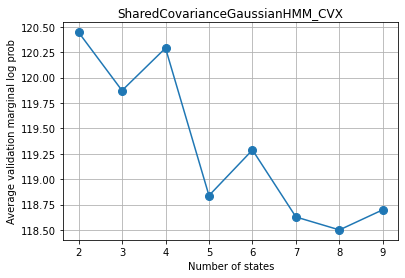


 === Fitting data from DHR === 


 === Starting fitting with 2 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 3 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 4 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 5 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 6 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 7 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 8 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 9 states === 



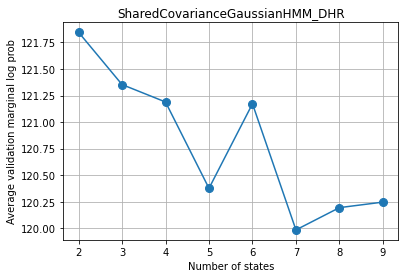


 === Fitting data from DIS === 


 === Starting fitting with 2 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 3 states === 

 |████████████████████| 100.00% [50/50 00:02<00:00]
 === Starting fitting with 4 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 5 states === 

 |████████████████████| 100.00% [50/50 00:02<00:00]
 === Starting fitting with 6 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 7 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 8 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 9 states === 



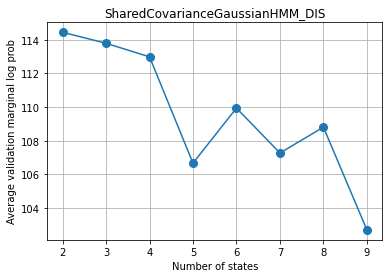


 === Fitting data from GOOGL === 


 === Starting fitting with 2 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 3 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 4 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 5 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 6 states === 

 |████████████████████| 100.00% [50/50 00:02<00:00]
 === Starting fitting with 7 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 8 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 9 states === 



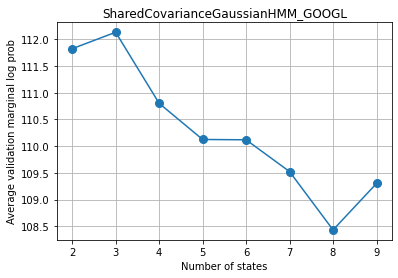


 === Fitting data from HD === 


 === Starting fitting with 2 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 3 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 4 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 5 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 6 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 7 states === 

 |████████████████████| 100.00% [50/50 00:02<00:00]
 === Starting fitting with 8 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 9 states === 



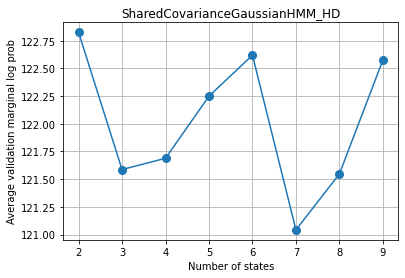


 === Fitting data from JNJ === 


 === Starting fitting with 2 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 3 states === 

 |████████████████████| 100.00% [50/50 00:05<00:00]
 === Starting fitting with 4 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 5 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 6 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 7 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 8 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 9 states === 



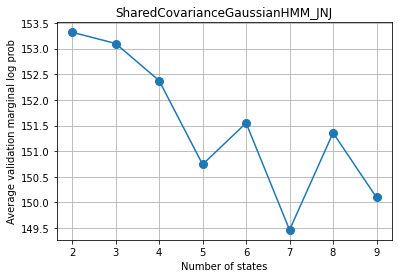


 === Fitting data from JPM === 


 === Starting fitting with 2 states === 

 |████████████████████| 100.00% [50/50 00:04<00:00]
 === Starting fitting with 3 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 4 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 5 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 6 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 7 states === 

 |████████████████████| 100.00% [50/50 00:08<00:00]
 === Starting fitting with 8 states === 

 |████████████████████| 100.00% [50/50 00:04<00:00]
 === Starting fitting with 9 states === 



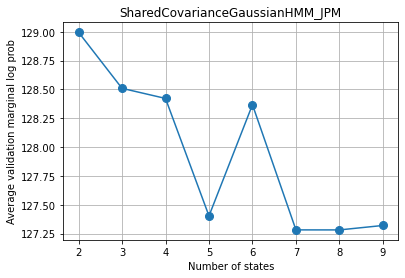


 === Fitting data from KO === 


 === Starting fitting with 2 states === 

 |████████████████████| 100.00% [50/50 00:04<00:00]
 === Starting fitting with 3 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 4 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 5 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 6 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 7 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 8 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 9 states === 



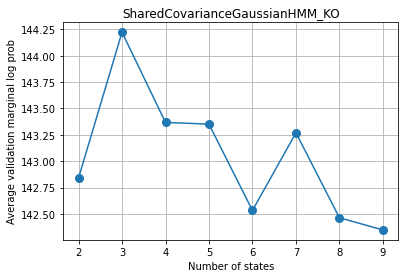


 === Fitting data from LIN === 


 === Starting fitting with 2 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 3 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 4 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 5 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 6 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 7 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 8 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 9 states === 



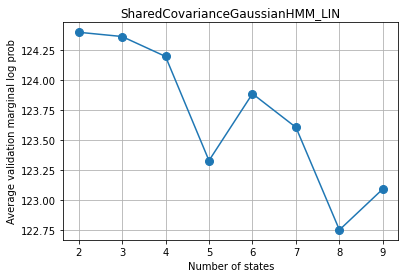


 === Fitting data from LLY === 


 === Starting fitting with 2 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 3 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 4 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 5 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 6 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 7 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 8 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 9 states === 



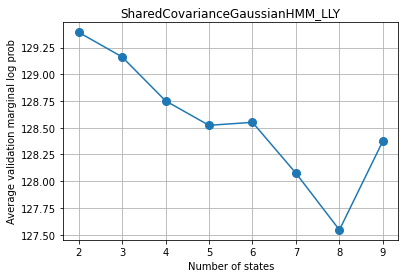


 === Fitting data from MA === 


 === Starting fitting with 2 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 3 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 4 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 5 states === 

 |████████████████████| 100.00% [50/50 00:04<00:00]
 === Starting fitting with 6 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 7 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 8 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 9 states === 



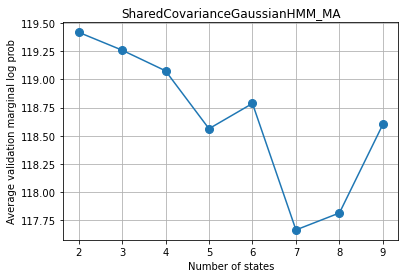


 === Fitting data from MCD === 


 === Starting fitting with 2 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 3 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 4 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 5 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 6 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 7 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 8 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 9 states === 



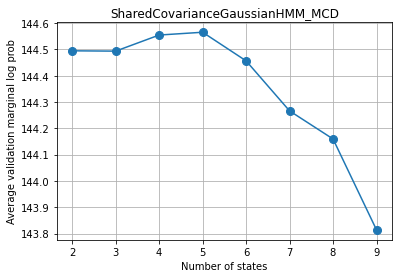


 === Fitting data from META === 


 === Starting fitting with 2 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 3 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 4 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 5 states === 

 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 6 states === 

 |████████████████████| 100.00% [50/50 00:04<00:00]
 === Starting fitting with 7 states === 



2023-02-23 01:58:15.890242: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_em_step] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-02-23 01:58:21.666849: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 2m10.626748359s

********************************
[Compiling module jit_em_step] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


 |████████████████████| 100.00% [50/50 00:01<00:00]
 === Starting fitting with 8 states === 

Error in callback <function stop_sys_pipes at 0x7f6b0c44baf0> (for post_execute):


KeyboardInterrupt: 

[SpyderKernelApp] ERROR | KeyboardInterrupt caught in kernel.


In [ ]:
stk_avg_ll = {}
stk_num_states = {}
for s in stk_folds:
    print(f'\n === Fitting data from {s} === \n')
    stk_avg_ll[s] = gh.cross_val_states_em(model, states, stk_folds[s], init_method, key)
    stk_num_states[s] = states[jnp.argmax(stk_avg_ll[s])]
    plt.plot(states, stk_avg_ll[s], '.-', markersize = 16)
    plt.xlabel('Number of states')
    plt.ylabel('Average validation marginal log prob')
    plt.title(f'{model.__name__}_{s}')
    plt.grid()
    plt.show()
    plt.close()

In [ ]:
# Data normalized by open price
norm_stocks = hd.norm_hlc_by_open(stocks, inplace = False)
batches_hlc = hd.batches_norm_hlc_by_open(stocks, period_len)